In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
df = pd.read_csv('final_data.csv')

In [3]:
df = df.drop(['Title'],axis=1)

# Encoding

In [4]:
from sklearn.preprocessing import OneHotEncoder,TargetEncoder,OrdinalEncoder
df[['City','floor_level','Is_in_Dhaka']] = OrdinalEncoder(handle_unknown='error').fit_transform(df[['City','floor_level','Is_in_Dhaka']])

In [5]:
df[['location_area']] = TargetEncoder().fit_transform(df[['location_area']],df[['Price_in_Cr']])

In [6]:
x = df.drop(['Price_in_Cr'],axis=1)
y = df['Price_in_Cr']

# Scalling

In [7]:
from sklearn.preprocessing import StandardScaler

x_scaled = StandardScaler().fit_transform(x)


# (1) Correlation

In [8]:
px.imshow(df.corr(),text_auto=True,width=800,height=600)

In [9]:
fi_df1 = df.corr()['Price_in_Cr'].to_frame().sort_values(by='Price_in_Cr',ascending=False).reset_index().rename({'index':'Features','Price_in_Cr':'Importance'},axis=1)

In [10]:
fi_df1

,Features,Importance
0,Price_in_Cr,1.000000
1,Price_per_sqft,0.877645
2,Floor_area,0.819041
3,location_area,0.736711
4,Bathrooms,0.547007
5,Bedrooms,0.491993
6,Is_in_Dhaka,0.179655
7,City,0.008057
8,floor_level,-0.053174


In [11]:
fi_df1.tail(3)

,Features,Importance
6,Is_in_Dhaka,0.179655
7,City,0.008057
8,floor_level,-0.053174


# (2) Random Forest Feature Importance

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,random_state=0).fit(x_scaled,y)

fi_df2 = pd.DataFrame({'Features':x.columns,'RF_Importance':rf.feature_importances_}).sort_values(by='RF_Importance',ascending=False)
fi_df2

,Features,RF_Importance
5,Price_per_sqft,0.553417
2,Floor_area,0.429360
4,location_area,0.014159
1,Bathrooms,0.001082
6,floor_level,0.000815
0,Bedrooms,0.000474
3,City,0.000450
7,Is_in_Dhaka,0.000242


In [13]:
fi_df2.tail(3)

,Features,RF_Importance
0,Bedrooms,0.000474
3,City,0.000450
7,Is_in_Dhaka,0.000242


# (3) Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100,random_state=0).fit(x_scaled,y)

fi_df3 = pd.DataFrame({'Features':x.columns,'GB_Importance':gb.feature_importances_}).sort_values(by='GB_Importance',ascending=False)
fi_df3

,Features,GB_Importance
5,Price_per_sqft,0.504056
2,Floor_area,0.488555
4,location_area,0.006958
0,Bedrooms,0.000172
3,City,0.000112
1,Bathrooms,0.000078
6,floor_level,0.000045
7,Is_in_Dhaka,0.000023


# (4) Lasso

In [15]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1).fit(x_scaled,y)

fi_df4 = pd.DataFrame({'Features':x.columns,'lasso_Importance': lasso.coef_}).sort_values(by='lasso_Importance',ascending=False)
fi_df4

,Features,lasso_Importance
5,Price_per_sqft,0.370587
2,Floor_area,0.281456
4,location_area,0.003352
0,Bedrooms,0.000000
3,City,0.000000
1,Bathrooms,0.000000
6,floor_level,-0.000000
7,Is_in_Dhaka,0.000000


# (5) Recursive Feature Elimination
## Backward Subset Selection (mlxtend) 

In [16]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100,random_state=0)
          ,n_features_to_select=x.shape[0]).fit(x_scaled,y)

features = x.columns[rfe.support_]
Importance = rfe.estimator_.feature_importances_

fi_df5 = pd.DataFrame({'Features':features,'RFE_Importance':Importance}).sort_values(by='RFE_Importance',ascending=False)
fi_df5

,Features,RFE_Importance
5,Price_per_sqft,0.553417
2,Floor_area,0.429360
4,location_area,0.014159
1,Bathrooms,0.001082
6,floor_level,0.000815
0,Bedrooms,0.000474
3,City,0.000450
7,Is_in_Dhaka,0.000242


# (6) Permutation Importance

In [17]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.2,random_state=0)

rf = RandomForestRegressor(n_estimators=100,random_state=0)
rf.fit(x_train,y_train)

pi = permutation_importance(estimator=rf,X=x_test,y=y_test,scoring='neg_mean_squared_error',n_repeats=10,random_state=0)

fi_df6 = pd.DataFrame({'Features':x.columns,'PI_Importance':pi.importances_mean}).sort_values(by='PI_Importance',ascending=False)
fi_df6

,Features,PI_Importance
5,Price_per_sqft,0.371248
2,Floor_area,0.264243
4,location_area,0.005248
3,City,0.000363
1,Bathrooms,0.000218
0,Bedrooms,-0.000013
6,floor_level,-0.000028
7,Is_in_Dhaka,-0.000120


# (7) Shap values

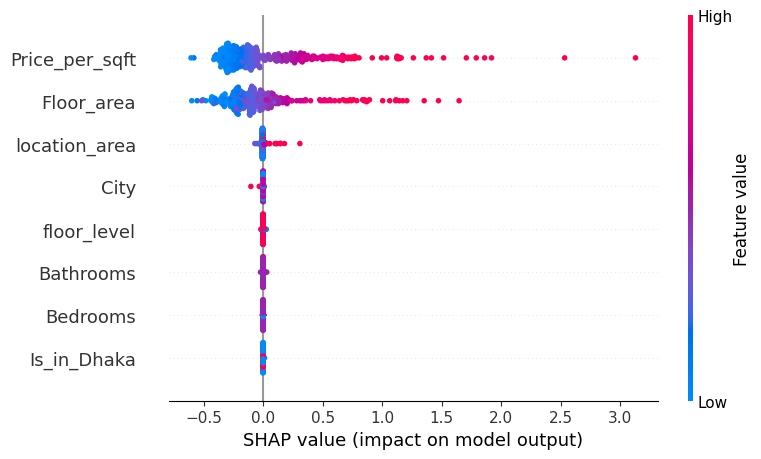

In [20]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer(x_test,check_additivity=False)

shap.summary_plot(shap_values,x_test,feature_names=x.columns)

In [30]:
fi_df7 = pd.DataFrame({'Features':x.columns,'Shap_Importance':np.abs((shap_values.values).mean(axis=0))}).sort_values(by='Shap_Importance',ascending=False)
fi_df7

,Features,Shap_Importance
5,Price_per_sqft,0.036490
2,Floor_area,0.027255
3,City,0.000554
4,location_area,0.000199
1,Bathrooms,0.000185
7,Is_in_Dhaka,0.000060
6,floor_level,0.000044
0,Bedrooms,0.000042


# Merge ALL fi_df

In [39]:
final_df = fi_df1.merge(fi_df2,on='Features').merge(fi_df3,on='Features').merge(fi_df4,on='Features').merge(fi_df5,on='Features').merge(fi_df6,on='Features').merge(fi_df7,on='Features').set_index('Features')

In [40]:
final_df

,Importance,RF_Importance,GB_Importance,lasso_Importance,RFE_Importance,PI_Importance,Shap_Importance
Features,,,,,,,
Price_per_sqft,0.877645,0.553417,0.504056,0.370587,0.553417,0.371248,0.036490
Floor_area,0.819041,0.429360,0.488555,0.281456,0.429360,0.264243,0.027255
location_area,0.736711,0.014159,0.006958,0.003352,0.014159,0.005248,0.000199
Bathrooms,0.547007,0.001082,0.000078,0.000000,0.001082,0.000218,0.000185
Bedrooms,0.491993,0.000474,0.000172,0.000000,0.000474,-0.000013,0.000042
Is_in_Dhaka,0.179655,0.000242,0.000023,0.000000,0.000242,-0.000120,0.000060
City,0.008057,0.000450,0.000112,0.000000,0.000450,0.000363,0.000554
floor_level,-0.053174,0.000815,0.000045,-0.000000,0.000815,-0.000028,0.000044


## Normalization (Dividing each column by it's Column sum)

In [41]:
final_df.divide(final_df.sum(axis=0),axis=1)

,Importance,RF_Importance,GB_Importance,lasso_Importance,RFE_Importance,PI_Importance,Shap_Importance
Features,,,,,,,
Price_per_sqft,0.243322,0.553417,0.504056,0.565440,0.553417,0.579026,0.562864
Floor_area,0.227074,0.429360,0.488555,0.429445,0.429360,0.412133,0.420415
location_area,0.204248,0.014159,0.006958,0.005115,0.014159,0.008185,0.003077
Bathrooms,0.151654,0.001082,0.000078,0.000000,0.001082,0.000340,0.002851
Bedrooms,0.136402,0.000474,0.000172,0.000000,0.000474,-0.000020,0.000642
Is_in_Dhaka,0.049808,0.000242,0.000023,0.000000,0.000242,-0.000187,0.000924
City,0.002234,0.000450,0.000112,0.000000,0.000450,0.000567,0.008551
floor_level,-0.014742,0.000815,0.000045,-0.000000,0.000815,-0.000044,0.000676


In [45]:
final_df.mean(axis=1).sort_values(ascending=False).to_frame('Importance')

,Importance
Features,
Price_per_sqft,0.466694
Floor_area,0.391324
location_area,0.111541
Bathrooms,0.078522
Bedrooms,0.070449
Is_in_Dhaka,0.025729
City,0.001427
floor_level,-0.007355


In [ ]:
from sklearn.model_selection import cross_val_score,KFold

cv_original = cross_val_score(estimator=rf,X=x_scaled,y=y,scoring='neg_mean_squared_error',cv=10)
cv_original.mean()

np.float64(-0.010179995030106071)

In [56]:
cv_after = cross_val_score(estimator=rf,X=x.drop(['Is_in_Dhaka','City','floor_level','Bedrooms','Bathrooms'],axis=1),
                           y=y,scoring='neg_mean_squared_error',cv=10)
cv_after.mean()

np.float64(-0.00986459507404096)

Main Features are Price_per_sqft , Floor_area and location_area,  
After removing other columns the cross validation MSE reached lowest at 0.0098